# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data
def read_data():
    training_file = '../train.p'
    testing_file = '../test.p'

    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    X_train, y_train = train['features'], train['labels']
    X_test, y_test = test['features'], test['labels']
    return X_train,y_train,X_test,y_test

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### To start off let's do a basic data summary.
X_train,y_train,X_test,y_test = read_data()

# TODO: number of training examples
n_train = len(X_train)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train[0].shape

# TODO: how many classes are in the dataset
n_classes = len(set(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

#### Plot Traffic Sign Images

In [4]:
import csv
with open('signnames.csv', mode='r') as infile:
    reader = csv.reader(infile)
    signnames = dict(row[:2] for row in reader if row)

In [5]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i], cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(signnames[str(cls_true[i])])
        else:
            xlabel = "True: {0}, Pred: {1}".format(signnames[str(cls_true[i])], signnames[str(cls_pred[i])])

        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])

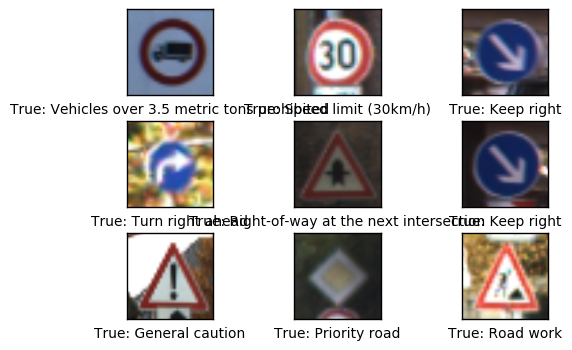

In [6]:
plot_images(X_test[0:9],y_test[0:9])


#### Plot counts of each sign

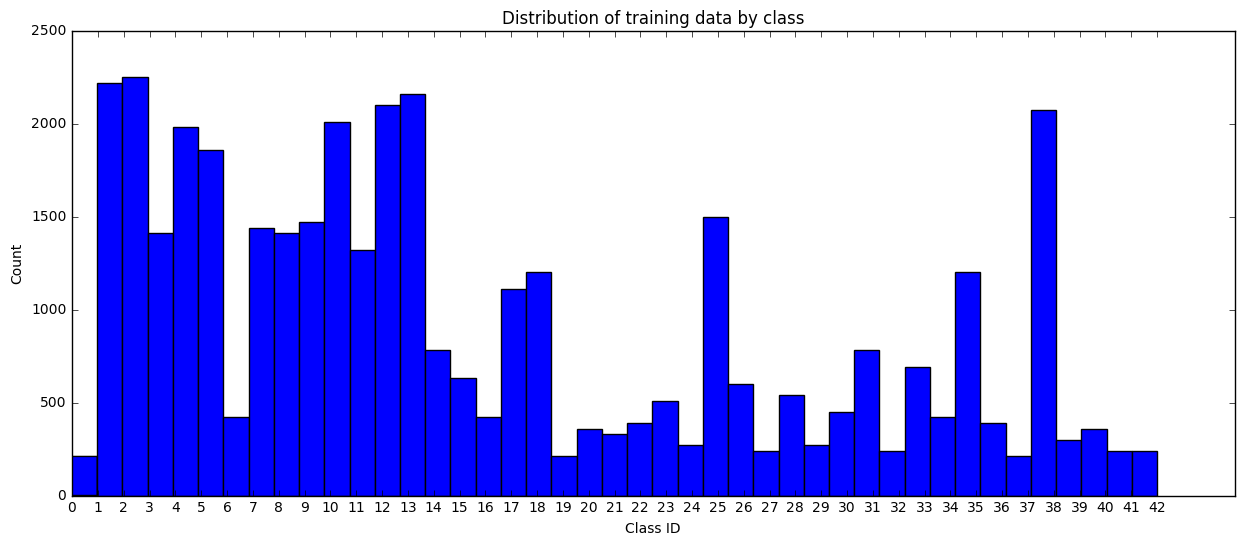

In [7]:
plt.figure(figsize=(15,6))
plt.hist(y_train,len(np.unique(y_train)))
plt.xticks(np.arange(min(y_train), max(y_train)+1, 1))
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.title("Distribution of training data by class")
plt.show()

We can see there is a severe class imbalance issue. If we building a model from this data directly, our model may underperform on test data that are overrepresented in the minority classes. So, we can address this issue by *jittering* our images to create new images, than sampling an equal number of images for each outcome class. This model may perform slightly worse in the validation data, but better in the test data and in the real world. 

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [8]:
import cv2
import tensorflow as tf

#1. Convert RGB to GrayScale
images = tf.placeholder(tf.float32,(None,32,32,3))
tf_rgb_to_grayscale = tf.image.rgb_to_grayscale(images)

#2. Standardize each image to have 0 mean and unit variance
gray_images = tf.placeholder(tf.float32,(None,32,32,1))
per_image_standard = tf.map_fn(tf.image.per_image_standardization,gray_images)



### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** 

I use 2 tensorflow functions for preprocessing:

1. RGB to Grayscale Conversion - Calculates the weighted average of the 3 channels for each pixel on the image.
2. Per Image Standardization - Given the grayscale intensity, normalize all the pixels to a zero norm and unit variance, on a per image basis.

Step 1 decreases the reliance of the classification on color. With this image classification task, it may be more beneficial to learn a model that relies more on the text and shape of the traffic sign, rather than the colors (which may be a source of noise). Step 2 normalizes values using per image standardization. This allows the learning algorithm to converge faster.  


In [9]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cv2

import numpy as np
%matplotlib inline
import matplotlib.image as mpimg

def transform_image(img,ang_range,shear_range,trans_range):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    Taken from Vivek Yadav: https://nbviewer.jupyter.org/github/vxy10/SCND_notebooks/blob/master/preprocessing_stuff/img_transform_NB.ipynb#
    '''
    
    # Rotation
    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    return img


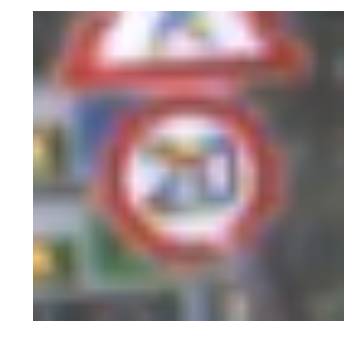

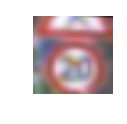

In [10]:
# Example:

image = X_train[0]
plt.imshow(image);
plt.axis('off');
gs1 = gridspec.GridSpec(10, 10)
gs1.update(wspace=0.01, hspace=0.02) # set the spacing between axes. 
plt.figure(figsize=(12,12))
for i in range(1):
    ax1 = plt.subplot(gs1[i])
    ax1.set_xticklabels([])
    ax1.set_yticklabels([])
    ax1.set_aspect('equal')
    img = transform_image(image,15,10,5)

    plt.subplot(10,10,i+1)
    plt.imshow(img,cmap='gray')
    plt.axis('off')

plt.show()

In [11]:
### Split the data into training/validation/testing sets here.
from sklearn.model_selection import train_test_split
X_train,X_validation, y_train, y_validation = train_test_split(X_train,y_train,test_size=.2,random_state = 0,stratify=y_train)

desired_imgs_per_class = 4000

### Generate data additional data (OPTIONAL!)
gen_imgs = []
gen_labels = []
for i in range(0,len(X_train)):
    img,lab = X_train[i],y_train[i]
    gen_imgs.append(img)
    gen_labels.append(lab)
    
    num_images_to_gen = round(desired_imgs_per_class*1.0/len(y_train[y_train==lab]))
    for j in range(num_images_to_gen):
        gen_imgs.append(transform_image(img,15,10,5))
        gen_labels.append(lab)    
    
    if i %10000==0:
        print(i)

### Feel free to use as many code cells as needed.

0
10000
20000
30000


In [12]:
def sample_from_gen_imgs_and_labels(gen_imgs,gen_labels,imgs_per_label=4000):
    """
    Sample imgs_per_label number of images from each class.
    """
    labels_images_dict = {}
    all_imgs = []
    all_labels = []
    
    for i in range(0,len(gen_imgs)):
        if gen_labels[i] in labels_images_dict:
            labels_images_dict[gen_labels[i]].append(gen_imgs[i])
        else:
            labels_images_dict[gen_labels[i]] = [gen_imgs[i]]
            
    for i in range(n_classes):
        sample_list = labels_images_dict[i]        
        np.random.shuffle(sample_list) 
        all_imgs.extend(sample_list[:imgs_per_label])
        all_labels.extend([i]*imgs_per_label)
    
    return all_imgs,all_labels
    


In [13]:
g_imgs,g_labels = sample_from_gen_imgs_and_labels(gen_imgs,gen_labels,imgs_per_label=3000)

In [14]:
X_train = np.array(g_imgs)
y_train = np.array(g_labels)
print(X_train.shape,y_train.shape)

(129000, 32, 32, 3) (129000,)


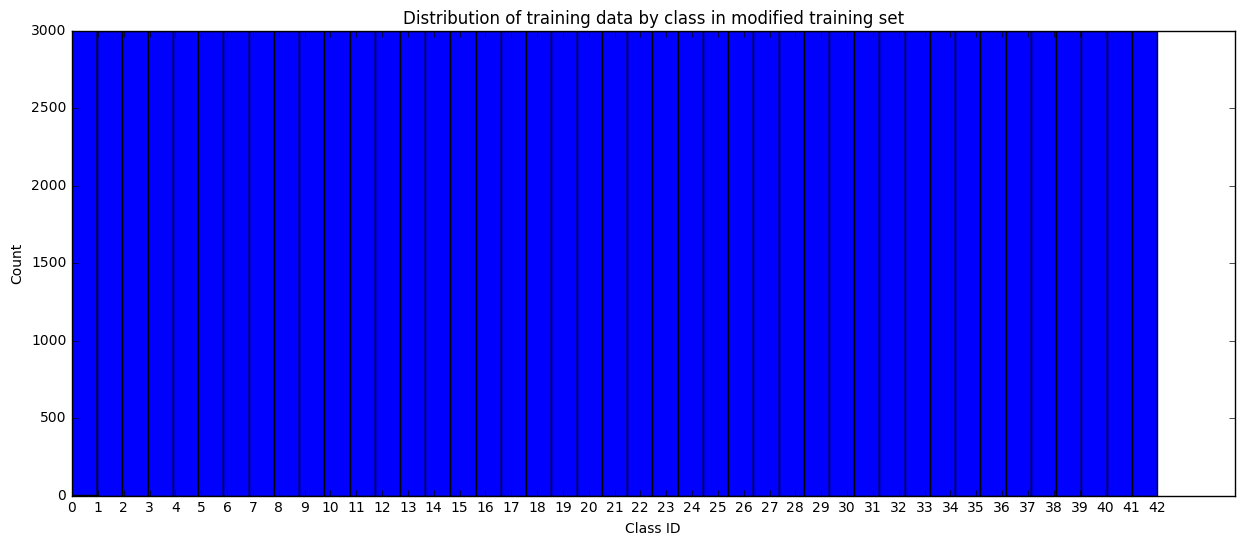

In [15]:
plt.figure(figsize=(15,6))
plt.hist(y_train,len(np.unique(y_train)))
plt.xticks(np.arange(min(y_train), max(y_train)+1, 1))
plt.xlabel("Class ID")
plt.ylabel("Count")
plt.title("Distribution of training data by class in modified training set")
plt.show()

In [16]:
#Apply preprocessing steps to X_train, X_Validation, X_test
with tf.Session() as session:
    imgs = session.run(tf_rgb_to_grayscale,feed_dict={images:X_train})
    X_train = session.run(per_image_standard,feed_dict={gray_images:imgs})
    imgs = session.run(tf_rgb_to_grayscale,feed_dict={images:X_validation})
    X_validation = session.run(per_image_standard,feed_dict={gray_images:imgs})
    imgs = session.run(tf_rgb_to_grayscale,feed_dict={images:X_test})
    X_test = session.run(per_image_standard,feed_dict={gray_images:imgs})


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

1. Using train_test_split, stratifying on the label, I divided the training data into training (80%) and validation (20%) sets. Test remained as it was (from the pickled test data), with a label distribution similar to the validation data.

2. Generated new data, using a classmate's function, that performs a random amount of rotation, shear and translation of a given image. For each image in the training data, this function was applied multiple times to generate enough images, so that I could sample 3000 images from each class for the training data. The original training are also included in the training data, which consists of 129,000 images, with an equal number of images in each class.


In [17]:
### Define your architecture here.
### Feel free to use as many code cells as needed.
from tensorflow.contrib.layers import flatten

def LeNet(x,input_channels,dropout):    
    """
    Modified LeNet
    1. Input is 32x32x3
    2. Output has 43 classes
    """

    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32xinput_channels. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, input_channels, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #conv1 = tf.nn.dropout(conv1,dropout)

    # Layer 2: Convolutional. Input 14x14x6. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Dropout
    conv2 = tf.nn.dropout(conv2,dropout)
    
    # Layer 3: Convolutional. Input 10x10x16. Output = 6x6x32.
    conv3_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 16, 32), mean = mu, stddev = sigma))
    conv3_b = tf.Variable(tf.zeros(32))
    conv3   = tf.nn.conv2d(conv2, conv3_W, strides=[1, 1, 1, 1], padding='VALID') + conv3_b
    
    # Activation.
    conv3 = tf.nn.relu(conv3)

    # Dropout
    conv3 = tf.nn.dropout(conv3,dropout)

    # Flatten. Input = 6x6x32. Output = 1152.
    fc0   = flatten(conv3)
    
    # Layer 4: Fully Connected. Input = 1152. Output = 400.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(1152, 400), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(400))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation
    fc1    = tf.nn.relu(fc1)
    
    # Layer 5: Fully Connected. Input = 400. Output = 120
    fc2_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc2_b = tf.Variable(tf.zeros(120))
    fc2   = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation
    fc2    = tf.nn.relu(fc2)

    # Layer 6: Fully Connected. Input = 120. Output = 84.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(84))
    fc3    = tf.matmul(fc2, fc3_W) + fc3_b
    
    # Activation.
    fc3    = tf.nn.relu(fc3)
    fc3 = tf.nn.dropout(fc3,dropout)

    # Layer 7: Fully Connected. Input = 84. Output = 43.
    fc4_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc4_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc3, fc4_W) + fc4_b
    
    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Final architecture is a Convolutional Neural Network with 7 layers: 

** Convolution **:

1. Convolution (5x5 filter with stride of 1, channels from 1 -> 6, 32x32 -> 28x28)  + Relu + Max Pooling (2x2 window, with a stride of 1, 28x28 -> 14x14)
2. Convolution (5x5 filter with stride of 1, channels from 6 -> 16, 14x14-> 10x10) + Relu + Dropout (.75)
3. Convolution (5x5 filter with stride of 1, channels from 16 -> 32, 10x10 -> 6x6) + Relu + Dropout (.75)

** Fully Connected **:

4. Fully Connected + Relu: 1152 inputs, and 400 outputs
5. Fully Connected + Relu: 400 inputs, and 120 outputs
6. Fully Connected + Relu: 120 inputs, and 83 outputs
7. Fully Connected: 84 inputs, and 43 output classes




In [18]:
import tensorflow as tf
from sklearn.utils import shuffle

#constants + hyperparameters
EPOCHS = 7
BATCH_SIZE = 128
INPUT_CHANNELS=1
rate = 0.001

#Input, output placeholders
x = tf.placeholder(tf.float32, (None, 32, 32, INPUT_CHANNELS))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

#Apply softmax to logits, minimize loss using AdamOptimizer
logits = LeNet(x,INPUT_CHANNELS,keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

#Evaluation framework used on validation data
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob:1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [19]:
#Train
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:.75})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet_traffic_signs')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.853

EPOCH 2 ...
Validation Accuracy = 0.939

EPOCH 3 ...
Validation Accuracy = 0.961

EPOCH 4 ...
Validation Accuracy = 0.969

EPOCH 5 ...
Validation Accuracy = 0.980

EPOCH 6 ...
Validation Accuracy = 0.980

EPOCH 7 ...
Validation Accuracy = 0.986

Model saved


In [20]:
##TEST - do not do until after model selection

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))


Test Accuracy = 0.956


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The model was trained using an ADAM Optimizer for 10 epochs with batch sizes of 128 and a constant learning rate of 0.001. After each epoch of training, the error on the validation set was calculated.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

In terms of preprocessing, I focused on applying grayscale conversion and normalization preprocessing steps, and designed a simple pipeline to convert the imbalanced training data to a balanced dataset with perturbed images (using a classmate's useful method for applying affine transformations to an image). 

Having addressed the class imbalance issue, I focused on modifying the LeNet architecture to improve the validation error. It took a process of trial and error to converge to a slightly better architecture. Here are all of the improvements that were made to the initial LeNet architecture:

** Increase depth of model **:

- Added 1 layers of Convolution and 1 Fully Connected layers. Adding convolution layers increases the number of channels in each subsequent layer (or increases the depth of the model). Up to a certain point, this had the effect of improving the validation accuracy. 

** Substitute max-pooling with dropout **:

- Replacing max-pooling with dropout. As it was mentioned in class, max-pooling has fallen out of favor in recent years in favor of dropout. I added dropout after every convolution layer except the first one, AND after the final fully connected layer. 

With the LeNet architecture:

- The average validation accuracy in the last 4 epochs of training was around 95.0%
- The testing accuracy was 92.3%

After modifying the ConvNet structure, to increase the depth and substitute max-pooling with dropout:

- Average validation accuracy in the last 4 epochs was around 97.9%
- The testing accuracy was 95.6%

I believe the discrepancy between Test and Validation error may be explained by 2 things:

1. How the validation data was selected. In the Yann Lecunn benchmark paper, the validation set is carefully generated by extracting 1 track at random per class for validation. This yields a more meaningful (realistic) validation set. I think using such an approach here would have a yielded accuracies more similar to what was achieved on the test data.

2. Overfitting. The model's performance is superior on the validation data, and doesn't generalize especially well in the real world cases (see Part 3 below). I think  there is reason to believe that the model is overfitting to the training data. It may be worth expanding the jittering approach to include randomization in brightness/contrast and color. Additionally, adding overfitting treatment mechanisms like dropout/regularization into the network might be useful. 


---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

True Label:  Priority road
Predicted Label:  Priority road
Original Downloaded Image


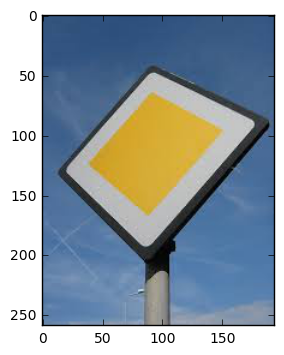

Resized Image


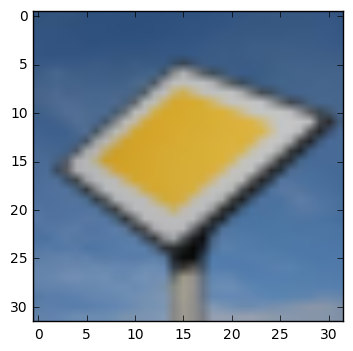

True Label:  Keep right
Predicted Label:  Keep left
Original Downloaded Image


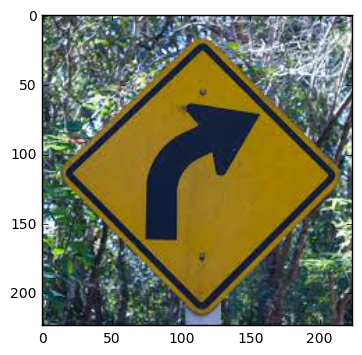

Resized Image


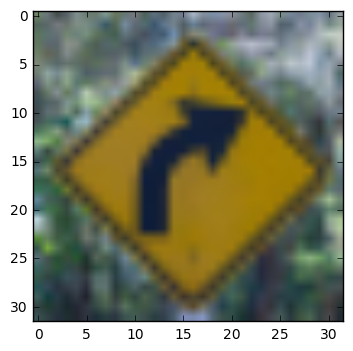

True Label:  Stop
Predicted Label:  Stop
Original Downloaded Image


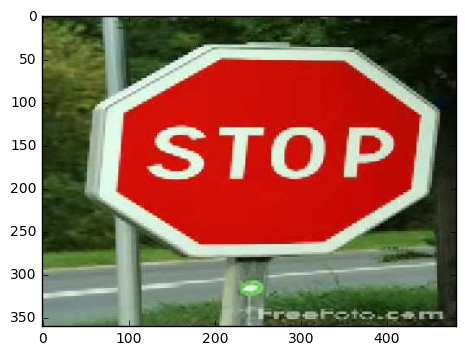

Resized Image


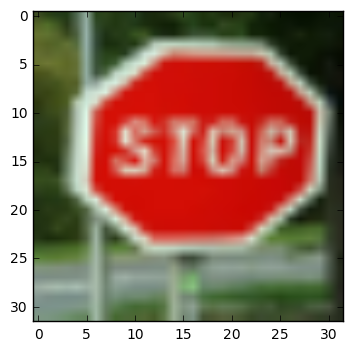

True Label:  Stop
Predicted Label:  Roundabout mandatory
Original Downloaded Image


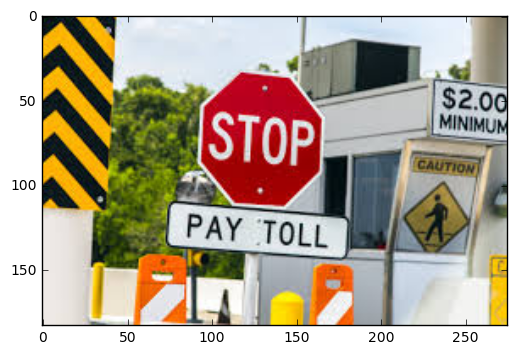

Resized Image


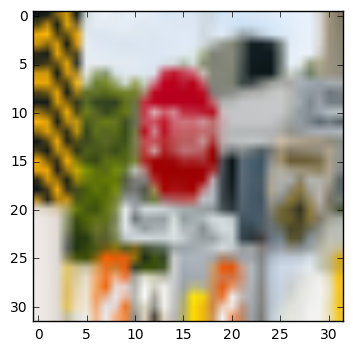

True Label:  No entry
Predicted Label:  No entry
Original Downloaded Image


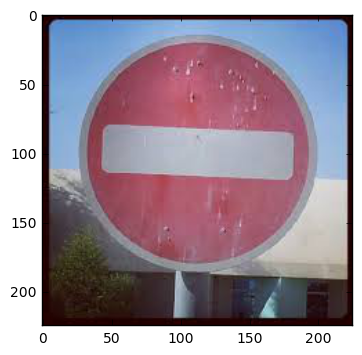

Resized Image


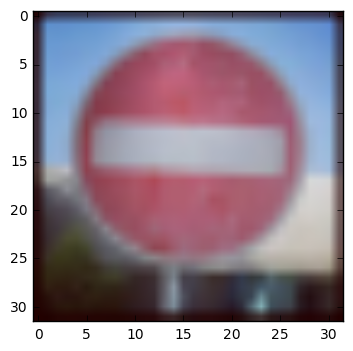

True Label:  Speed limit (80km/h)
Predicted Label:  Bicycles crossing
Original Downloaded Image


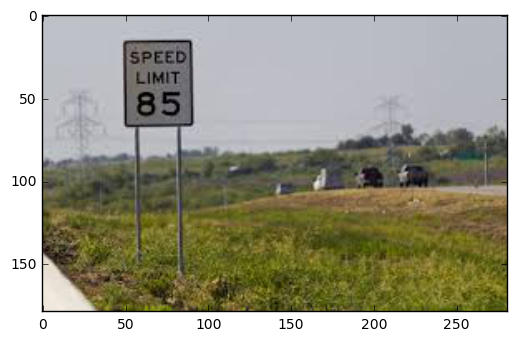

Resized Image


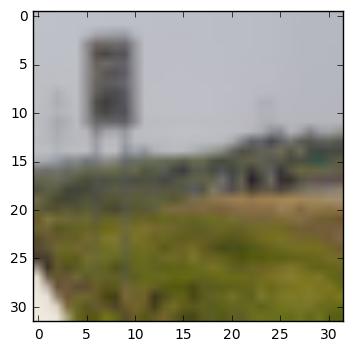

True Label:  no class
Predicted Label:  Speed limit (30km/h)
Original Downloaded Image


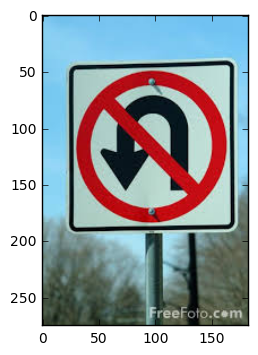

Resized Image


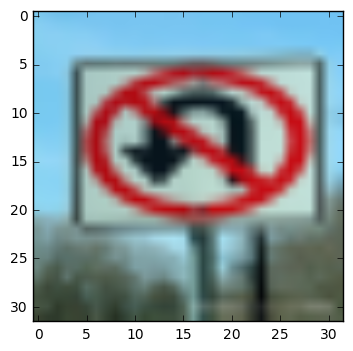

True Label:  no class
Predicted Label:  Speed limit (50km/h)
Original Downloaded Image


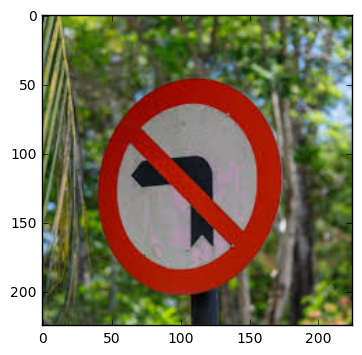

Resized Image


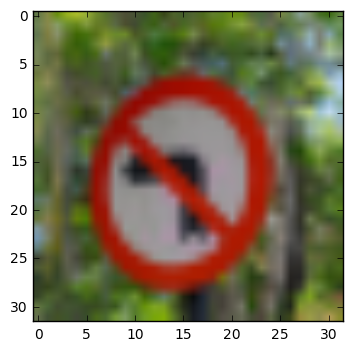

True Label:  Wild animals crossing
Predicted Label:  Road work
Original Downloaded Image


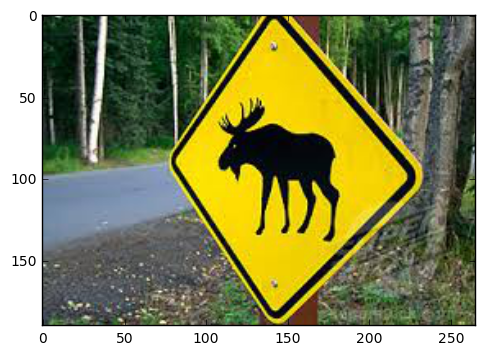

Resized Image


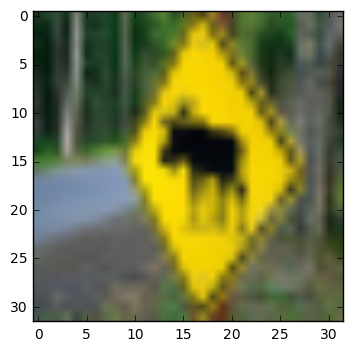

True Label:  Wild animals crossing
Predicted Label:  Slippery road
Original Downloaded Image


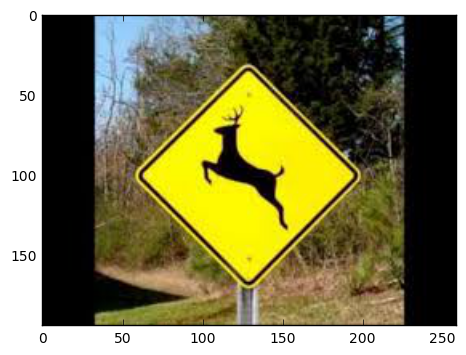

Resized Image


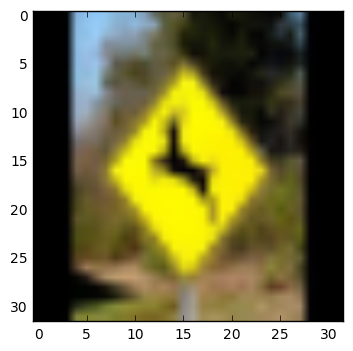

True Label:  Pedestrians
Predicted Label:  General caution
Original Downloaded Image


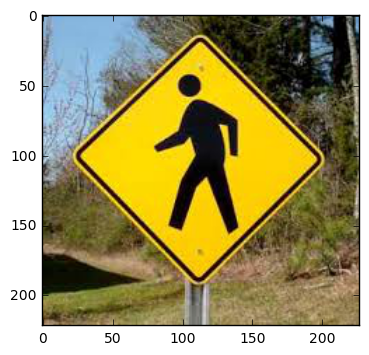

Resized Image


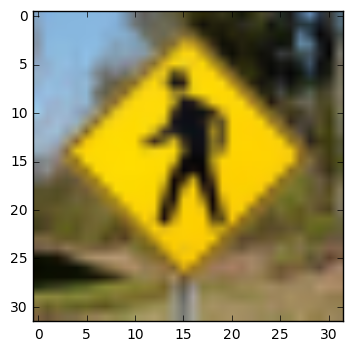

True Label:  Yield
Predicted Label:  Turn right ahead
Original Downloaded Image


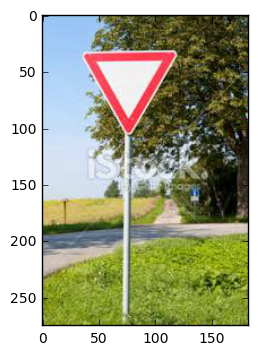

Resized Image


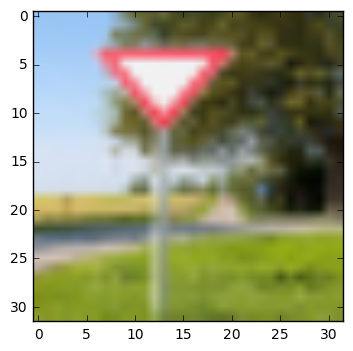

True Label:  no class
Predicted Label:  Slippery road
Original Downloaded Image


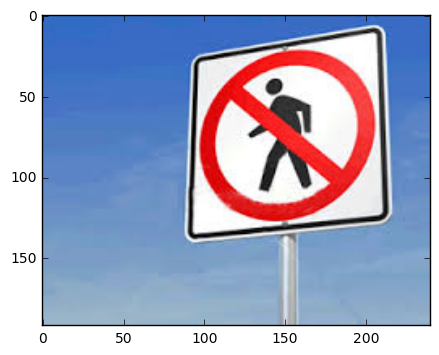

Resized Image


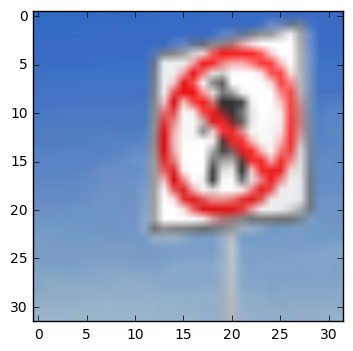

True Label:  Speed limit (50km/h)
Predicted Label:  Speed limit (80km/h)
Original Downloaded Image


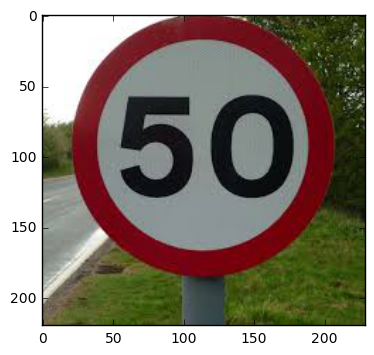

Resized Image


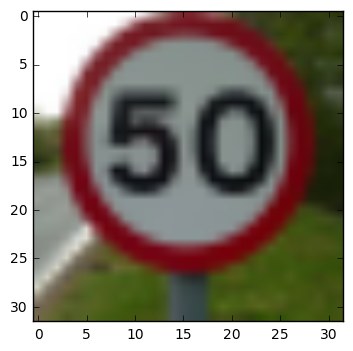

In [57]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
def resize_img(path_to_image):
    return cv2.resize(cv2.imread(path_to_image), (32,32), interpolation = cv2.INTER_AREA)

import glob
new_signs_filenames = glob.glob('../new_signs/*')

def get_true_class(filename):
    return str(filename.split("new_signs")[1].split("sign")[1].split("_")[-1].split(".")[0])

signnames['100'] = 'no class'

prediction = tf.argmax(logits, 1)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    for filename in new_signs_filenames:
        true_class = get_true_class(filename)
        true_label = signnames[true_class]
        resized_image = resize_img(filename)
        
        #predicted class
        imgs = sess.run(tf_rgb_to_grayscale,feed_dict={images:np.array([resized_image])})
        new_imgs = sess.run(per_image_standard,feed_dict={gray_images:imgs})
        pred = str(sess.run(prediction, feed_dict={x:new_imgs , keep_prob:1.0})[0])

        print("True Label: ", true_label)
        print("Predicted Label: ",signnames[pred])
        print("Original Downloaded Image")
        plt.imshow(cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB))
        plt.show()
        print("Resized Image")
        plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
        plt.show()
        #map predicted class to string class
        #compare


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

There are 14 images above: 

- When the images contain more than just the sign (for example, the stop sign above the pay toll sign, surrounded by the toll booth), the model is getting confused by the stimuli in the image. So, in about half of the images above, issues arrise because the sign does not occupy the whole picture. 

- I believe issues like the blurring (caused by the resizing of images), may also contribute to misclassifications (although, the jittered training data should be able to address some of this issue). 

- Again, things like rotation, and varying locations of the sign within the image should be addressed by the jittered dataset. 

- Finally, some of these signs are just unfamiliar to the classifier. So, I don't expect good performance on classes such as *wild animal crossing*, since the animal on the sign may be different from what the model has learned on in the dataset.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** 

[See cell 57 for the results]

Amongst the 11/14 images that have a label (3 downloaded signs do not take on 1 of the 43 labels), the model has a strict accuracy of 3/11, or **27%**. 2 cases are near misses (Keep Right classified as Keep left, and a 50 KM speed sign classified as an 80 KM speed signs). Other mis-classifications may be due to the sign being a small part of the entire image, and/or the specific variation of the sign not having been seen before (wild animal sign with moose on it). 

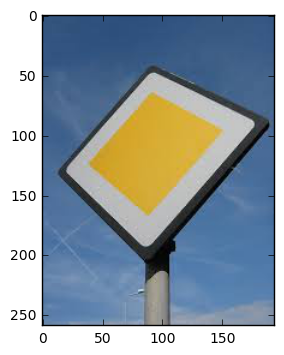

Priority road Priority road 1.0
Priority road Roundabout mandatory 7.30527e-10
Priority road Keep right 2.77935e-13
Priority road Right-of-way at the next intersection 6.53132e-15
Priority road No entry 3.18421e-15


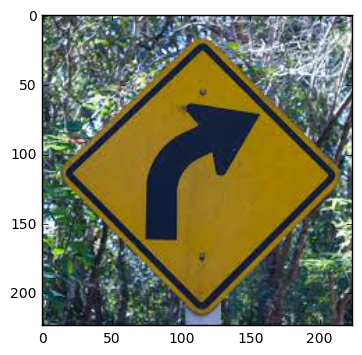

Keep right Keep left 0.991962
Keep right Speed limit (70km/h) 0.00363694
Keep right No vehicles 0.00135306
Keep right End of all speed and passing limits 0.00105341
Keep right Speed limit (30km/h) 0.000642108


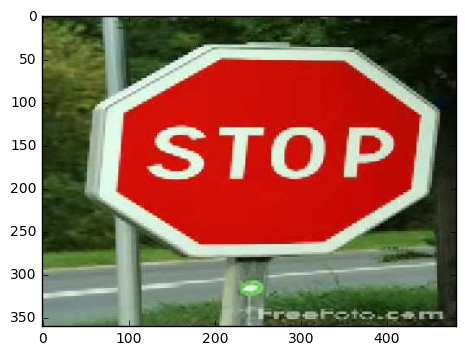

Stop Stop 0.984494
Stop Speed limit (60km/h) 0.0154844
Stop Turn left ahead 1.92739e-05
Stop Keep right 1.4873e-06
Stop Turn right ahead 4.28178e-07


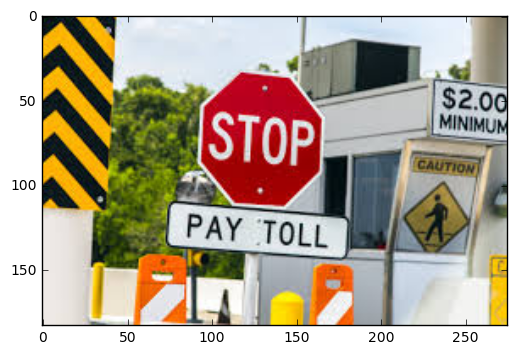

Stop Roundabout mandatory 0.384017
Stop Priority road 0.177076
Stop Vehicles over 3.5 metric tons prohibited 0.125169
Stop Keep right 0.0905193
Stop Right-of-way at the next intersection 0.0647334


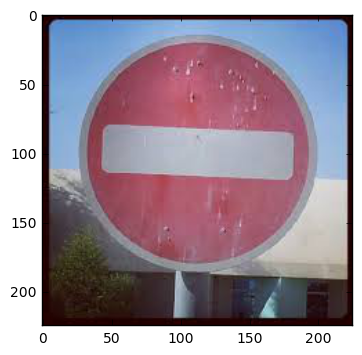

No entry No entry 0.97438
No entry Keep right 0.010423
No entry Turn left ahead 0.0102884
No entry Roundabout mandatory 0.00205949
No entry No passing 0.00120339


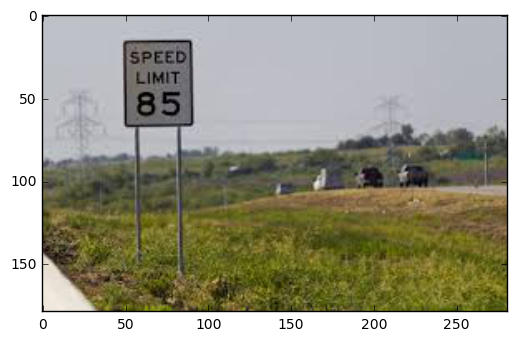

Speed limit (80km/h) Bicycles crossing 0.283757
Speed limit (80km/h) Bumpy road 0.265687
Speed limit (80km/h) No passing 0.112205
Speed limit (80km/h) Speed limit (120km/h) 0.0827438
Speed limit (80km/h) Wild animals crossing 0.0708038


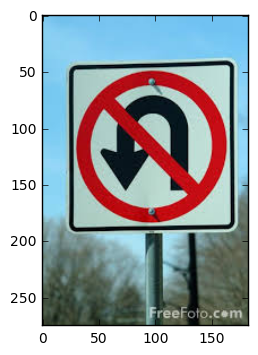

no class Speed limit (30km/h) 0.678338
no class Speed limit (50km/h) 0.291367
no class Speed limit (80km/h) 0.0240601
no class Speed limit (100km/h) 0.00544373
no class Roundabout mandatory 0.000305975


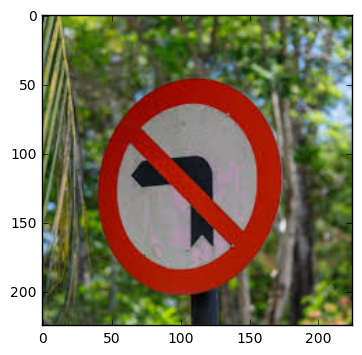

no class Speed limit (50km/h) 0.718513
no class No passing for vehicles over 3.5 metric tons 0.272979
no class Yield 0.00849844
no class Speed limit (80km/h) 3.69937e-06
no class Keep right 3.44909e-06


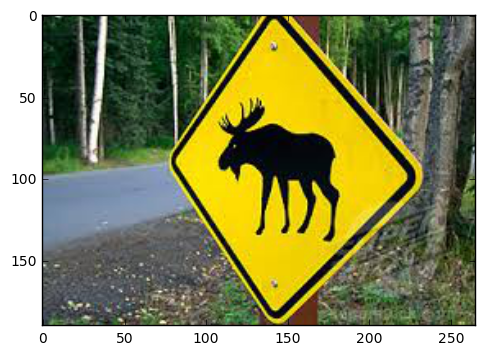

Wild animals crossing Road work 0.96132
Wild animals crossing General caution 0.0256754
Wild animals crossing Pedestrians 0.00586169
Wild animals crossing Keep right 0.00240346
Wild animals crossing Right-of-way at the next intersection 0.00189463


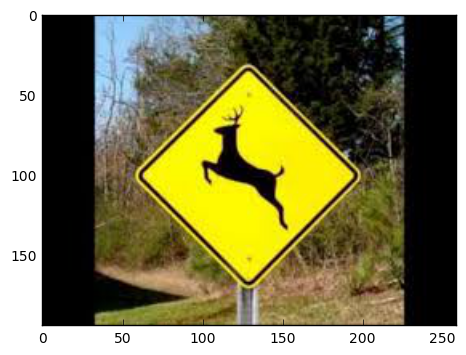

Wild animals crossing Slippery road 0.295054
Wild animals crossing Double curve 0.28525
Wild animals crossing Wild animals crossing 0.218204
Wild animals crossing No passing for vehicles over 3.5 metric tons 0.195235
Wild animals crossing Dangerous curve to the left 0.00508647


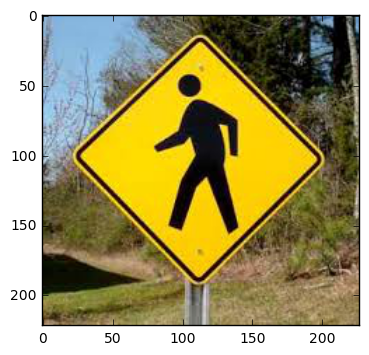

Pedestrians General caution 0.955115
Pedestrians Pedestrians 0.0378782
Pedestrians Traffic signals 0.00352903
Pedestrians Road work 0.00209589
Pedestrians Speed limit (70km/h) 0.000741209


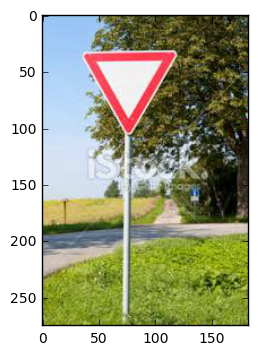

Yield Turn right ahead 0.439993
Yield Roundabout mandatory 0.421224
Yield Vehicles over 3.5 metric tons prohibited 0.0247139
Yield Speed limit (100km/h) 0.0233469
Yield Speed limit (30km/h) 0.0167999


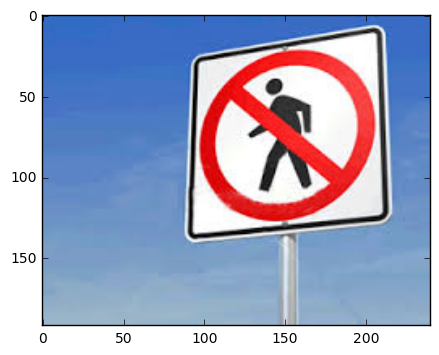

no class Slippery road 0.632226
no class Double curve 0.312653
no class Wild animals crossing 0.055074
no class Dangerous curve to the left 1.67209e-05
no class Road work 1.54024e-05


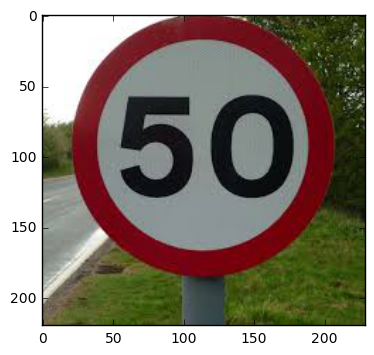

Speed limit (50km/h) Speed limit (80km/h) 0.827232
Speed limit (50km/h) Speed limit (50km/h) 0.141835
Speed limit (50km/h) Speed limit (60km/h) 0.0282429
Speed limit (50km/h) Speed limit (30km/h) 0.00225691
Speed limit (50km/h) No passing for vehicles over 3.5 metric tons 0.000219766


In [85]:
"""
Question 8
"""
top_k_preds = tf.nn.top_k(tf.nn.softmax(logits),k=5)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    for filename in new_signs_filenames:
        true_class = get_true_class(filename)
        true_label = signnames[true_class]
        resized_image = resize_img(filename)
        plt.imshow(cv2.cvtColor(cv2.imread(filename), cv2.COLOR_BGR2RGB))
        plt.show()
        #predicted class
        imgs = sess.run(tf_rgb_to_grayscale,feed_dict={images:np.array([resized_image])})
        new_imgs = sess.run(per_image_standard,feed_dict={gray_images:imgs})
        preds = sess.run(top_k_preds, feed_dict={x:new_imgs , keep_prob:1.0})
        for i in range(0,5):
            print(true_label,signnames[str(preds[1][0][i])],preds[0][0][i])            


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

- With k = 5, the true class is within the top 5 predictions in 6/11 cases. So, there is 54% top 5 accuracy. 
- In 6 cases, the model gives a probability of >.9 to a class, it is correct in 3/6 of these cases. The Keep Right sign is confidently predicted as Keep Left (which is a mis-classification, but it a close miss). Suprisingly, Keep Right is not one of the top 5 choices for this prediction. 
- Also surprising that the 'Yield' label is not one of the top five predictions for the Yield sign.
- Finally, although the 50 KM speed limit sign has the true label as the 2nd highest option at 15%, i think this is a poor miss. Especially with advances in digit classification (handwritten, house numbers, etc), I think I should be able to make improvements to the training data or the network to make this classification more robust. In practice, this kind of misclassification could have very dire consequences to a self-driving car, so it's essential to have (nearly) perfect recall especially on stop signs and speed limit signs.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

### References

1. Hvass Tensorflow Tutorials: https://github.com/Hvass-Labs/TensorFlow-Tutorials
2. Vivek Yadav's Notebook on Generating Transformed Images: https://nbviewer.jupyter.org/github/vxy10/SCND_notebooks/blob/master/preprocessing_stuff/img_transform_NB.ipynb#
